# Evaluate on Test Data

## Setup

In [1]:
from importlib import reload

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas

from hot_dust import preprocess, model

2024-01-26 14:07:16.760807: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-26 14:07:16.801901: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-26 14:07:16.801936: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-26 14:07:16.802616: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-26 14:07:16.808091: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-26 14:07:16.808660: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# "reload" to get changes in preprocess.py without restarting the kernel
reload(preprocess)
reload(model)
from hot_dust.preprocess import prepare_training_data, split_training_data
from hot_dust.model import to_tensorflow

In [3]:
ds = prepare_training_data()
train, validate, test = to_tensorflow(split_training_data(ds))
batch_size = test.cardinality()
test = test.batch(batch_size)

## Model Summary

In [4]:
network = tf.keras.models.load_model("data/network", compile=False)
network.summary() 


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 normalization (Normalizati  (None, 9)                 19        
 on)                                                             
                                                                 
 dense (Dense)               (None, 16)                160       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 468 (1.83 KB)
Trainable params: 449 (1.75 KB)
Non-trainable params: 19 (80.00 Byte)
_____________________________

## Metrics

In [5]:
# Calculate metrics (.eg MSE, R2) on test data and tabulate

y = np.concatenate(list(i[1] for i in test.as_numpy_iterator()))  # true values
y_hat = network.predict(test, verbose=0).reshape((-1,))  # predicted values

# Calculate the MSE
MSE = np.square(np.subtract(y, y_hat)).mean()

# Calculate R2
y_mean = np.mean(y)  # mean of the true values
SS_total = np.sum((y - y_mean) ** 2)  # total sum of squares
SS_reg = np.sum((y - y_hat) ** 2)  #  sum of squares due to regression

R2 = 1 - (SS_reg / SS_total)

# Return the metrics
print("Metrics: ")
print("Mean Squared Error: " + str(MSE))
print("R2: " + str(R2))

Metrics: 
Mean Squared Error: 0.06092693
R2: 0.933825708925724


## Plots

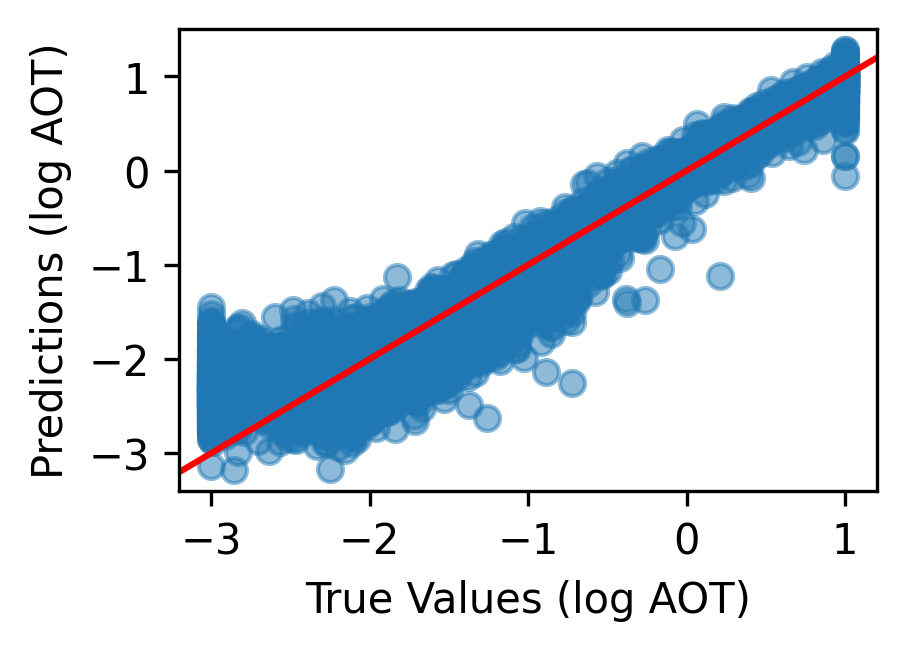

In [6]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=300)

# Plot of y_hat against y, with a one-to-one line overlayed
# plot y_hat against y
plt.scatter(y, y_hat, alpha=0.5)

# lables
plt.xlabel("True Values (log AOT)")
plt.ylabel("Predictions (log AOT)")
#plt.title("Predicted Values v. True Values")

# one-to-one line overlay
plt.axline([0, 0], slope=1, color="red")

plt.show()

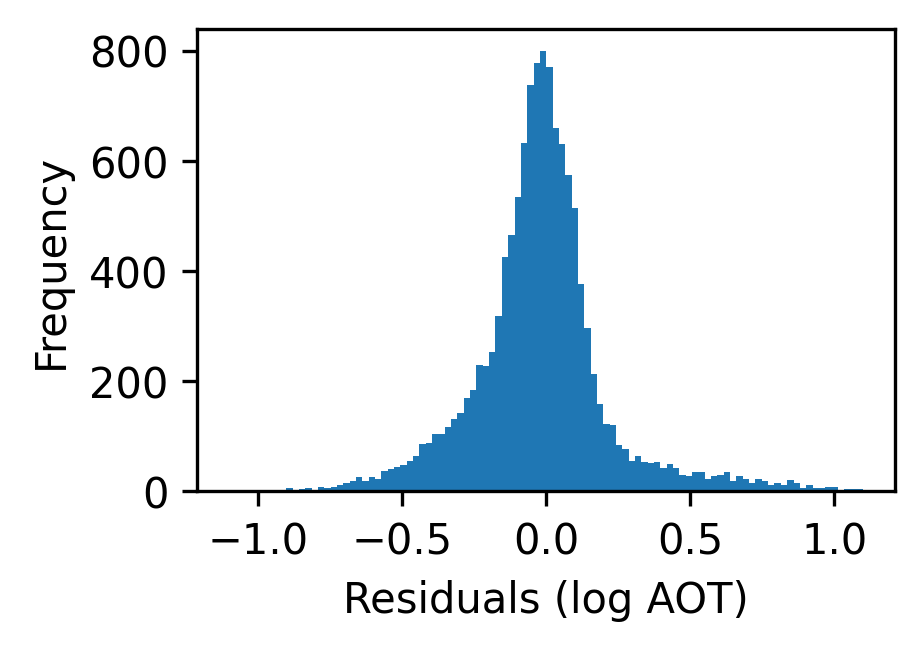

In [7]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=300)

# Plot a histogram of the residuals
residual = y_hat - y
num_bins = 100
plt.hist(residual, num_bins, range=[-1.1, 1.1])
plt.xlabel("Residuals (log AOT)")
plt.ylabel("Frequency")

#plt.title("Histogram of the Residuals")
plt.show()

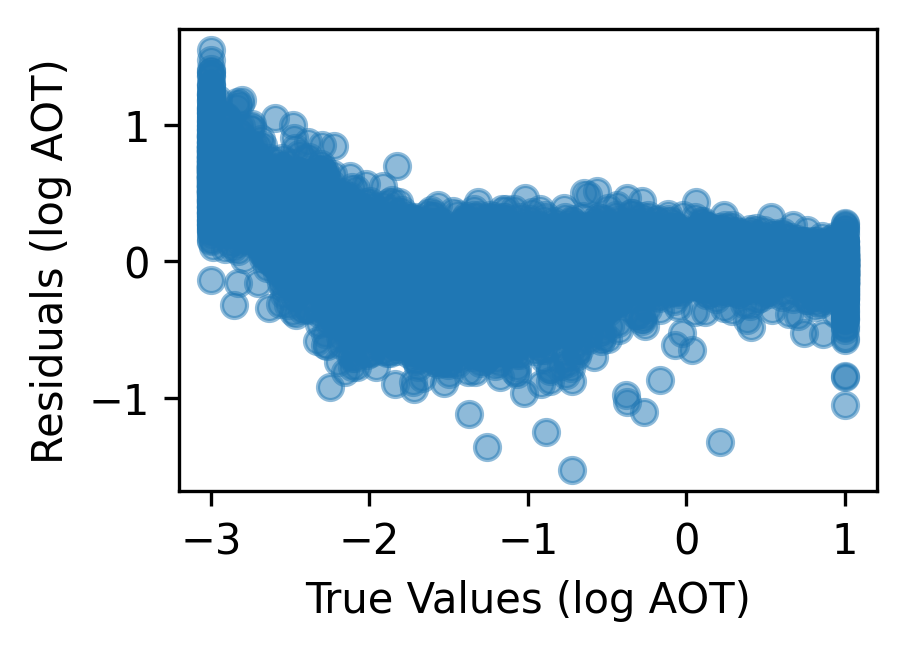

In [8]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=300)

# Plot of the residuals against y
plt.scatter(y, residual, alpha=0.5)
# lables
plt.xlabel("True Values (log AOT)")
plt.ylabel("Residuals (log AOT)")
#plt.title("Residuals v. True Values")
plt.show()

## Heat Maps 

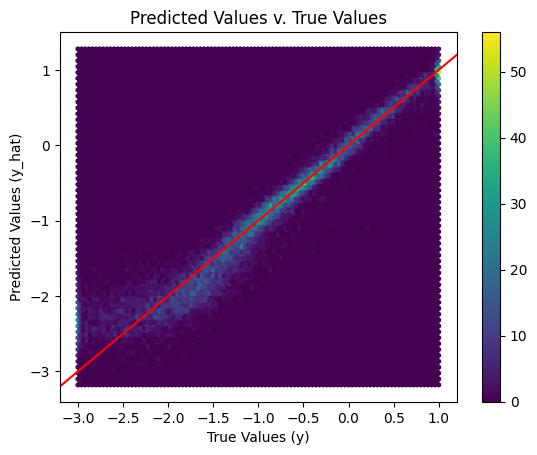

In [9]:
# Heat map of y_hat against y

# create the heatmap of y_hat against y
plt.hexbin(y, y_hat, cmap="viridis")
# set the size of the graph
plt.axis("auto")
# lables
plt.xlabel("True Values (y)")
plt.ylabel("Predicted Values (y_hat)")
plt.title("Predicted Values v. True Values")
# one-to-one line overlay
plt.axline([0, 0], slope=1, color="red")
plt.colorbar()

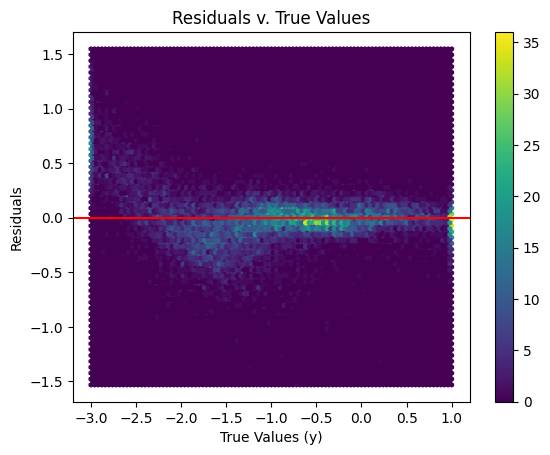

In [10]:
# Heat map of the residuals against y

# create the heatmap of residuals against y
plt.hexbin(y, residual, cmap="viridis")
# set the size of the graph
plt.axis("auto")
# lables
plt.xlabel("True Values (y)")
plt.ylabel("Residuals")
plt.title("Residuals v. True Values")
# zero horizontal line overlay
plt.axline([0, 0], slope=0, color="red")
plt.colorbar()